# Actividad 2
## Tema 6-1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# tamaño batch, arbitrario
BATCH_SIZE = 32

C:\Users\imayz\.virtualenvs\hds-zbVMaGVs\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] No se puede encontrar el módulo especificado
  warn(f"Failed to load image Python extension: {e}")


Un tensor es una matriz multidimensional n x m x k, similar a aun array

In [3]:
# tranformaciones apllicadas a las imagenes, imagen -> tensor
transform = transforms.Compose(
    [transforms.ToTensor()])


Crear train y test sets.
num_workers = 0, windows no soporta >0 para cpu

In [4]:
trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)


trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=0)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=0)


Ver imagenes

In [6]:
# obtner primer batch
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [8]:
# dimensiones del tensor
# batch x canal x alto x ancho
images.shape

torch.Size([32, 1, 28, 28])

Primer imagen del bacth

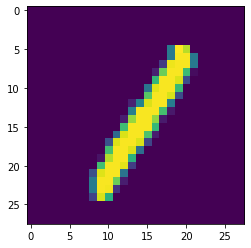

In [9]:
primera = images[0].numpy()
primera = np.transpose(primera, (1, 2, 0))
plt.imshow(primera)

Definicion del modelo
modelo con 1 capa convolucional con kernel de tamaño 3 y 2 tranformacione lineales

In [14]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1,
                              out_channels=32,
                              kernel_size=3)
        # tamaño del kernel ?
        # out chanel 32?

        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)

        # funcion de activacion
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        # funcion de activacion d1
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)

        # salida softmax
        out = F.softmax(logits, dim=1)
        return out


Entrenar modelo

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()

# modelo CNN 
model = model.to(device)

## Parametros del modelo ---
# lr y veces que se entrena
learning_rate = 0.001
num_epochs = 5
# funcion de perdida
# CrossEntropyLoss para clasificaion multiclase
criterion = nn.CrossEntropyLoss()

# algortimo de optimizacion
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate)


In [17]:
# funcion para calcular precision 
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [18]:
# iterar sobre epochs
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        
        # scores
        logits = model(images)
        # perdida
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)


    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' %(epoch, train_running_loss / i, train_acc/i))


Epoch: 0 | Loss: 1.6252 | Train Accuracy: 83.96
Epoch: 1 | Loss: 1.4910 | Train Accuracy: 97.30
Epoch: 2 | Loss: 1.4816 | Train Accuracy: 98.16
Epoch: 3 | Loss: 1.4771 | Train Accuracy: 98.60
Epoch: 4 | Loss: 1.4739 | Train Accuracy: 98.91


In [19]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 97.90


In [20]:
# guardar modelo localmente
# torch.save(model.state_dict(), "D:/Descargas/HDS/Modulo 6/Semana 14/61/trained_model.pt")

Realizar prediccion sobre los dos primeros elementos

In [21]:
test_image = iter(testloader)
images_test, labels_test = test_image.next()

In [22]:
# probar sobre dos imagenes
images_test[0:2].shape
y_pred = model(images_test[0:2])

In [23]:
max_index = torch.max(y_pred, 1)[1]

In [26]:
print("Valor predicciones:", max_index.data.numpy().squeeze())
print("valores reales:",  labels_test[0:2].numpy())


Valor predicciones: [7 2]
valores reales: [7 2]


## Conclusiones 
Me sorprendió el nivel de precisión que alcanzo en modelo con este data set, el tutorial es relativamente sencillo de seguir, logre entrenar la red e incluso probar la red para ver los valores de las predicciones sobre algunos elementos del set de test y comprobar que los resultados eran acertados.

Considero que este tutorial tiene cierto grado de complejidad en la parte teórica, ya que omite varios conceptos, y requiere un entendimiento previo de como funciona una CNN y otros conceptos. He visto varios tutoriales similares, y creo que tienen a sobre simplificar el tema, lo que puede crear interpretación errónea del uso de redes y por ende una mala aplicación de estas.
Este tutorial creo más bien sirve para demostrar la facilidad de uso de pytorch, aún así no queda del todo claro el uso de los módulos de  la librería, tuve que leer directamente la documentación de pytorch para comprender su uso. 

Como conclusión esta actividad motiva a querer adentrase más en uso de modelos de DL, con las bases teóricas y técnicas es relativamente sencillo llevar a la práctica su aplicación.


